Epoch 1 | Loss: 0.7128 | Accuracy: 0.7560
Epoch 2 | Loss: 0.3761 | Accuracy: 0.8793
Epoch 3 | Loss: 0.2854 | Accuracy: 0.9085
Epoch 4 | Loss: 0.2432 | Accuracy: 0.9221
Epoch 5 | Loss: 0.2141 | Accuracy: 0.9320


<function matplotlib.pyplot.show(close=None, block=None)>

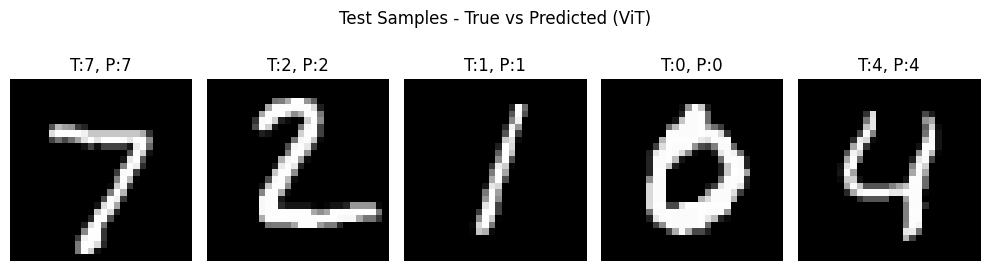

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader


In [ ]:

# --- 데이터 전처리 및 로딩 ---
transform = transforms.Compose([transforms.ToTensor()])
mnist_train = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_test = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
train_loader = DataLoader(mnist_train, batch_size=64, shuffle=True)
test_loader = DataLoader(mnist_test, batch_size=64, shuffle=False)

# --- Patch Embedding ---
class PatchEmbedding(nn.Module):
    def __init__(self, img_size=28, patch_size=7, in_channels=1, embed_dim=64):
        super().__init__()
        self.patch_size = patch_size
        self.n_patches = (img_size // patch_size) ** 2
        self.proj = nn.Conv2d(in_channels, embed_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        x = self.proj(x)  # [B, embed_dim, n_patches^0.5, n_patches^0.5]
        x = x.flatten(2).transpose(1, 2)  # [B, n_patches, embed_dim]
        return x

# --- Transformer Encoder ---
class TransformerEncoder(nn.Module):
    def __init__(self, embed_dim=64, num_heads=4, ff_dim=128, dropout=0.1):
        super().__init__()
        self.norm1 = nn.LayerNorm(embed_dim)
        self.attn = nn.MultiheadAttention(embed_dim, num_heads, dropout=dropout, batch_first=True)
        self.norm2 = nn.LayerNorm(embed_dim)
        self.ff = nn.Sequential(
            nn.Linear(embed_dim, ff_dim),
            nn.ReLU(),
            nn.Linear(ff_dim, embed_dim),
        )

    def forward(self, x):
        x = x + self.attn(self.norm1(x), self.norm1(x), self.norm1(x))[0]
        x = x + self.ff(self.norm2(x))
        return x


In [ ]:

# --- Vision Transformer ---
class SimpleViT(nn.Module):
    def __init__(self, img_size=28, patch_size=7, in_channels=1, num_classes=10, embed_dim=64, depth=1):
        super().__init__()
        self.patch_embed = PatchEmbedding(img_size, patch_size, in_channels, embed_dim)
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.pos_embed = nn.Parameter(torch.randn(1, (img_size // patch_size)**2 + 1, embed_dim))
        self.transformer = nn.Sequential(*[TransformerEncoder(embed_dim) for _ in range(depth)])
        self.mlp_head = nn.Sequential(nn.LayerNorm(embed_dim), nn.Linear(embed_dim, num_classes))

    def forward(self, x):
        B = x.size(0)
        x = self.patch_embed(x)
        cls_tokens = self.cls_token.expand(B, -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)
        x = x + self.pos_embed
        x = self.transformer(x)
        cls_out = x[:, 0]
        out = self.mlp_head(cls_out)
        return out

# --- 모델 학습 ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleViT().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

train_losses, train_accuracies = [], []

for epoch in range(5):
    model.train()
    total_loss, correct, total = 0, 0, 0
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        output = model(x)
        loss = criterion(output, y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * x.size(0)
        correct += (output.argmax(1) == y).sum().item()
        total += y.size(0)

    avg_loss = total_loss / total
    accuracy = correct / total
    train_losses.append(avg_loss)
    train_accuracies.append(accuracy)
    print(f"Epoch {epoch+1} | Loss: {avg_loss:.4f} | Accuracy: {accuracy:.4f}")


In [ ]:

# --- 테스트 샘플 예측 및 시각화 ---
model.eval()
samples = []
with torch.no_grad():
    for x, y in test_loader:
        x, y = x.to(device), y.to(device)
        output = model(x)
        preds = output.argmax(1)
        for i in range(5):
            samples.append((x[i].cpu().squeeze().numpy(), y[i].item(), preds[i].item()))
        break

plt.figure(figsize=(10, 3))
for i, (img, true_cls, pred_cls) in enumerate(samples):
    plt.subplot(1, 5, i+1)
    plt.imshow(img, cmap='gray')
    plt.title(f"T:{true_cls}, P:{pred_cls}")
    plt.axis('off')
plt.suptitle("Test Samples - True vs Predicted (ViT)")
plt.tight_layout()
plt.show